In [15]:
# # you will be prompted with a window asking to grant permissions
# from google.colab import drive
# drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [16]:
# # fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
# import os
# datadir = "/content/drive/Othercomputers/My Computer/Sem_2/DL for CV (CS_444)/assignment3/assignment3_part2"
# if not os.path.exists(datadir):
#   !ln -s "/content/drive/Othercomputers/My Computer/Sem_2/DL for CV (CS_444)/assignment3/assignment3_part2" $datadir # TODO: Fill your Assignment 3 path
# os.chdir(datadir)
# !pwd

/content/drive/Othercomputers/My Computer/Sem_2/DL for CV (CS_444)/assignment3/assignment3_part2


# In a terminal, Run the `download_data.sh` script in the data folder of assignment 3 part 2

In [9]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from src.resnet_yolo import resnet50
# import src.resnet_yolo
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialization

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [12]:
load_network_path = "./checkpoints/best_detector.pth"
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Loading saved network from ./checkpoints/best_detector.pth


In [ ]:
learning_rate = 0.001
num_epochs = 50
batch_size = 16

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [ ]:
file_root_train = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'data/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [ ]:
file_root_test = 'data/VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'data/voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


In [ ]:
data = train_dataset[0]

## Set up training tools

In [ ]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Train detector

In [ ]:
best_test_loss = np.inf
learning_rate = 1e-3
for epoch in range(num_epochs):
    net.train()

    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))

    total_loss = collections.defaultdict(int)

    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()

        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)

    # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')

    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')





Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [50/314], Loss: total=23.877, reg=60.621, containing_obj=5.191, no_obj=198.804, cls=117.420
Epoch [1/50], Iter [100/314], Loss: total=15.764, reg=52.332, containing_obj=6.789, no_obj=102.978, cls=90.123
Epoch [1/50], Iter [150/314], Loss: total=12.643, reg=47.394, containing_obj=7.894, no_obj=70.309, cls=76.698
Epoch [1/50], Iter [200/314], Loss: total=10.894, reg=44.184, containing_obj=8.572, no_obj=53.712, cls=67.833
Epoch [1/50], Iter [250/314], Loss: total=9.820, reg=42.257, containing_obj=9.126, no_obj=43.624, cls=62.106
Epoch [1/50], Iter [300/314], Loss: total=9.031, reg=40.761, containing_obj=9.518, no_obj=36.824, cls=57.398
Updating best test loss: 5.14996


Starting epoch 2 / 50
Learning Rate for this epoch: 0.001
Epoch [2/50], Iter [50/314], Loss: total=5.095, reg=33.162, containing_obj=12.643, no_obj=2.415, cls=33.296
Epoch [2/50], Iter [100/314], Loss: total=5.005, reg=32.636, containing_obj=12.

100%|██████████| 4950/4950 [01:47<00:00, 46.06it/s]


---class aeroplane ap 0.02579904554164365---
---class bicycle ap 0.0395415502240428---
---class bird ap 0.03993711554758411---
---class boat ap 0.0053146519593736605---
---class bottle ap 0.0---
---class bus ap 0.001564945226917058---
---class car ap 0.11336342216499673---
---class cat ap 0.022378110716099544---
---class chair ap 0.062132893965945---
---class cow ap 0.009908807039954582---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.020015963075779027---
---class horse ap 0.0066614420062695925---
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.046986400973536624---
---class pottedplant ap 0.004849266471415428---
---class sheep ap 0.05712563399540508---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.11243722244409818---
---map 0.028400823567653055---
4 [0.02579904554164365, 0.0395415502240428, 0.03993711554758411, 0.005314651959

100%|██████████| 4950/4950 [01:46<00:00, 46.46it/s]


---class aeroplane ap 0.04361751198911504---
---class bicycle ap 0.12054816603005324---
---class bird ap 0.03148360736376988---
---class boat ap 0.0245029826176534---
---class bottle ap 0.00454868514570007---
---class bus ap 0.06380284595400719---
---class car ap 0.24572964830720936---
---class cat ap 0.1678381697486257---
---class chair ap 0.13512026694584478---
---class cow ap 0.20007452848241142---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.15818523768088616---
---class horse ap 0.43624526615772785---
---class motorbike ap 0.163865080470693---
---class person ap 0.19195714020273194---
---class pottedplant ap 0.006995304335899292---
---class sheep ap 0.06648577302838614---
---class sofa ap 0.06890976217601605---
---class train ap 0.03663681032266765---
---class tvmonitor ap 0.34932855924704675---
---map 0.12579376731032227---
9 [0.04361751198911504, 0.12054816603005324, 0.03148360736376988, 0.0245029826176534, 0.00454868514570007, 0.0638028459540

100%|██████████| 4950/4950 [01:48<00:00, 45.58it/s]


---class aeroplane ap 0.425491339213653---
---class bicycle ap 0.501638078638001---
---class bird ap 0.31917857037107067---
---class boat ap 0.18799983879840107---
---class bottle ap 0.06681683822021522---
---class bus ap 0.49852312819056077---
---class car ap 0.4811456631370372---
---class cat ap 0.5526287776459413---
---class chair ap 0.21585931109276837---
---class cow ap 0.3238555989629769---
---class diningtable ap 0.07503256089157313---
---class dog ap 0.52540361730421---
---class horse ap 0.6125138739991949---
---class motorbike ap 0.4786781013966974---
---class person ap 0.4260801241337967---
---class pottedplant ap 0.07011627829562081---
---class sheep ap 0.18682669974866975---
---class sofa ap 0.28514409088349496---
---class train ap 0.5760043984198671---
---class tvmonitor ap 0.3609240541650077---
---map 0.35849304717543784---
14 [0.425491339213653, 0.501638078638001, 0.31917857037107067, 0.18799983879840107, 0.06681683822021522, 0.49852312819056077, 0.4811456631370372, 0.55

100%|██████████| 4950/4950 [01:50<00:00, 44.61it/s]


---class aeroplane ap 0.427194974632507---
---class bicycle ap 0.5596270642119525---
---class bird ap 0.40321709910402537---
---class boat ap 0.18261779824797716---
---class bottle ap 0.13045036272957428---
---class bus ap 0.5570369966486777---
---class car ap 0.5907401157408148---
---class cat ap 0.5802501940036786---
---class chair ap 0.2352636454315838---
---class cow ap 0.32333733830463---
---class diningtable ap 0.3005591417181426---
---class dog ap 0.5244574098230705---
---class horse ap 0.6124732740592488---
---class motorbike ap 0.5266202079972411---
---class person ap 0.45353687179805513---
---class pottedplant ap 0.09759810074881685---
---class sheep ap 0.32324006303251107---
---class sofa ap 0.3890661163916173---
---class train ap 0.5916776019695758---
---class tvmonitor ap 0.3922685702161983---
---map 0.41006164734049494---
19 [0.427194974632507, 0.5596270642119525, 0.40321709910402537, 0.18261779824797716, 0.13045036272957428, 0.5570369966486777, 0.5907401157408148, 0.5802

100%|██████████| 4950/4950 [01:51<00:00, 44.49it/s]


---class aeroplane ap 0.4505037220601483---
---class bicycle ap 0.5412124976706476---
---class bird ap 0.3863104335436506---
---class boat ap 0.26132960539822925---
---class bottle ap 0.10103449662475372---
---class bus ap 0.5514898812729354---
---class car ap 0.5964993625027557---
---class cat ap 0.6691273988181723---
---class chair ap 0.24888913260375392---
---class cow ap 0.43829753674843447---
---class diningtable ap 0.19669710711441885---
---class dog ap 0.5512869135966832---
---class horse ap 0.6467678654244222---
---class motorbike ap 0.47321875071984454---
---class person ap 0.44701820980035195---
---class pottedplant ap 0.10213198354824651---
---class sheep ap 0.3791849183975217---
---class sofa ap 0.41479868633860634---
---class train ap 0.6590322020042346---
---class tvmonitor ap 0.4033381008747309---
---map 0.42590844025312713---
24 [0.4505037220601483, 0.5412124976706476, 0.3863104335436506, 0.26132960539822925, 0.10103449662475372, 0.5514898812729354, 0.5964993625027557, 

100%|██████████| 4950/4950 [01:51<00:00, 44.43it/s]


---class aeroplane ap 0.41126163157535833---
---class bicycle ap 0.5376233033190487---
---class bird ap 0.42842912917828524---
---class boat ap 0.28133118680477576---
---class bottle ap 0.12174237433451518---
---class bus ap 0.5742922989854017---
---class car ap 0.6576425610991112---
---class cat ap 0.6458696011333911---
---class chair ap 0.3072026361260649---
---class cow ap 0.516528047144912---
---class diningtable ap 0.31640042008763464---
---class dog ap 0.6194327900739591---
---class horse ap 0.6634945367926943---
---class motorbike ap 0.5788056718720638---
---class person ap 0.4390126710357098---
---class pottedplant ap 0.15517106387308605---
---class sheep ap 0.4127287260951582---
---class sofa ap 0.43006783632947393---
---class train ap 0.6429565390227083---
---class tvmonitor ap 0.40307048529280204---
---map 0.45715317550880785---
29 [0.41126163157535833, 0.5376233033190487, 0.42842912917828524, 0.28133118680477576, 0.12174237433451518, 0.5742922989854017, 0.6576425610991112, 

100%|██████████| 4950/4950 [01:49<00:00, 45.20it/s]


---class aeroplane ap 0.4926227445561021---
---class bicycle ap 0.6284622937972044---
---class bird ap 0.5216318372834619---
---class boat ap 0.3430737877187289---
---class bottle ap 0.21685692228461817---
---class bus ap 0.6420901278438507---
---class car ap 0.6609840406907914---
---class cat ap 0.7400756471705996---
---class chair ap 0.3171078458964234---
---class cow ap 0.5704810858421299---
---class diningtable ap 0.2948642211657754---
---class dog ap 0.6713054636494775---
---class horse ap 0.6955965376160378---
---class motorbike ap 0.5947682009275925---
---class person ap 0.5326599964021347---
---class pottedplant ap 0.17405639422826547---
---class sheep ap 0.45953358153332247---
---class sofa ap 0.47664145081656395---
---class train ap 0.6987574434874726---
---class tvmonitor ap 0.49076280119629867---
---map 0.5111166212053426---
34 [0.4926227445561021, 0.6284622937972044, 0.5216318372834619, 0.3430737877187289, 0.21685692228461817, 0.6420901278438507, 0.6609840406907914, 0.7400

100%|██████████| 4950/4950 [01:49<00:00, 45.27it/s]


---class aeroplane ap 0.4552316576730359---
---class bicycle ap 0.5952849837633861---
---class bird ap 0.5237840167251112---
---class boat ap 0.34353391902144925---
---class bottle ap 0.21330642203617---
---class bus ap 0.6374927230877299---
---class car ap 0.6643249642792431---
---class cat ap 0.7228576337351325---
---class chair ap 0.3181636592635031---
---class cow ap 0.5598840735823218---
---class diningtable ap 0.30962955033748446---
---class dog ap 0.6670123761297166---
---class horse ap 0.6774185699862894---
---class motorbike ap 0.5599798189054567---
---class person ap 0.5374380369030576---
---class pottedplant ap 0.18584897079001286---
---class sheep ap 0.486180429115807---
---class sofa ap 0.49430752888299007---
---class train ap 0.6876033227138576---
---class tvmonitor ap 0.4973904732785337---
---map 0.5068336565105145---
39 [0.4552316576730359, 0.5952849837633861, 0.5237840167251112, 0.34353391902144925, 0.21330642203617, 0.6374927230877299, 0.6643249642792431, 0.7228576337

100%|██████████| 4950/4950 [01:49<00:00, 45.06it/s]


---class aeroplane ap 0.505505411038073---
---class bicycle ap 0.5912890446373611---
---class bird ap 0.4974106681122745---
---class boat ap 0.35102399445672816---
---class bottle ap 0.22637551659673774---
---class bus ap 0.6501618872140003---
---class car ap 0.6753270506296211---
---class cat ap 0.734779715330921---
---class chair ap 0.3271181339931194---
---class cow ap 0.5692164480517914---
---class diningtable ap 0.3027452372104708---
---class dog ap 0.6747625164645411---
---class horse ap 0.6724404978763928---
---class motorbike ap 0.5740097186696396---
---class person ap 0.5394617724934836---
---class pottedplant ap 0.18858053326322272---
---class sheep ap 0.4824121987569487---
---class sofa ap 0.5030495556506807---
---class train ap 0.7002573685256734---
---class tvmonitor ap 0.4970955190724138---
---map 0.5131511394022047---
44 [0.505505411038073, 0.5912890446373611, 0.4974106681122745, 0.35102399445672816, 0.22637551659673774, 0.6501618872140003, 0.6753270506296211, 0.73477971

100%|██████████| 4950/4950 [01:48<00:00, 45.65it/s]


---class aeroplane ap 0.4780850677586738---
---class bicycle ap 0.6120805079602427---
---class bird ap 0.47593157567465594---
---class boat ap 0.337813885570671---
---class bottle ap 0.22367451917829567---
---class bus ap 0.6445658204970999---
---class car ap 0.6664282834194264---
---class cat ap 0.7465064611342114---
---class chair ap 0.3271636148197135---
---class cow ap 0.5737807720559871---
---class diningtable ap 0.30706377353449477---
---class dog ap 0.6654476081670434---
---class horse ap 0.6745332178642549---
---class motorbike ap 0.5526914219046504---
---class person ap 0.5411335316615102---
---class pottedplant ap 0.18193764587005118---
---class sheep ap 0.4832681927807437---
---class sofa ap 0.4943922461536903---
---class train ap 0.7065892588708526---
---class tvmonitor ap 0.4912251111754804---
---map 0.5092156258025874---
49 [0.4780850677586738, 0.6120805079602427, 0.47593157567465594, 0.337813885570671, 0.22367451917829567, 0.6445658204970999, 0.6664282834194264, 0.746506

# View example predictions

predicting...


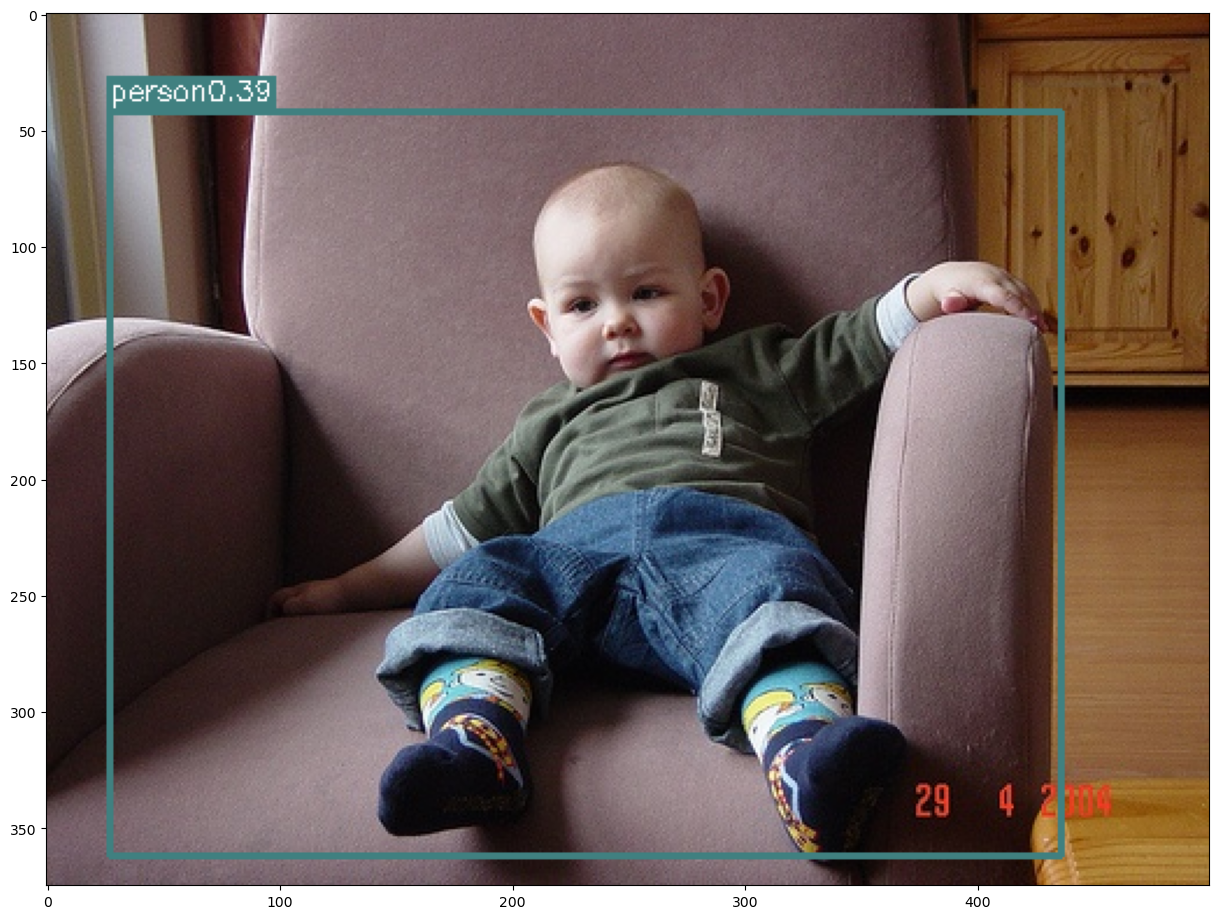

In [ ]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [ ]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:48<00:00, 45.83it/s]


---class aeroplane ap 0.4780850677586738---
---class bicycle ap 0.6120805079602427---
---class bird ap 0.47593157567465594---
---class boat ap 0.337813885570671---
---class bottle ap 0.22367451917829567---
---class bus ap 0.6445658204970999---
---class car ap 0.6664282834194264---
---class cat ap 0.7465064611342114---
---class chair ap 0.3271636148197135---
---class cow ap 0.5737807720559871---
---class diningtable ap 0.30706377353449477---
---class dog ap 0.6654476081670434---
---class horse ap 0.6745332178642549---
---class motorbike ap 0.5526914219046504---
---class person ap 0.5411335316615102---
---class pottedplant ap 0.18193764587005118---
---class sheep ap 0.4832681927807437---
---class sofa ap 0.4943922461536903---
---class train ap 0.7065892588708526---
---class tvmonitor ap 0.4912251111754804---
---map 0.5092156258025874---


### Cell added to get intermediate mAP values for students

In [ ]:
network_paths = ['./checkpoints/detector_epoch_%d.pth' % epoch for epoch in [5, 10, 20, 30, 40]]+['./checkpoints/detector.pth']
for load_network_path in network_paths:
    print('Loading saved network from {}'.format(load_network_path))
    net_loaded =  resnet50().to(device)
    net_loaded.load_state_dict(torch.load(load_network_path))
    evaluate(net_loaded, test_dataset_file=annotation_file_test, img_root=file_root_test)


Loading saved network from ./checkpoints/detector_epoch_5.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:41<00:00, 48.75it/s]


---class aeroplane ap 0.02579904554164365---
---class bicycle ap 0.0395415502240428---
---class bird ap 0.03993711554758411---
---class boat ap 0.0053146519593736605---
---class bottle ap 0.0---
---class bus ap 0.001564945226917058---
---class car ap 0.11336342216499673---
---class cat ap 0.022378110716099544---
---class chair ap 0.062132893965945---
---class cow ap 0.009908807039954582---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.020015963075779027---
---class horse ap 0.0066614420062695925---
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.046986400973536624---
---class pottedplant ap 0.004849266471415428---
---class sheep ap 0.05712563399540508---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.11243722244409818---
---map 0.028400823567653055---
Loading saved network from ./checkpoints/detector_epoch_10.pth
---Evaluate mode

100%|██████████| 4950/4950 [01:42<00:00, 48.15it/s]


---class aeroplane ap 0.04361751198911504---
---class bicycle ap 0.12054816603005324---
---class bird ap 0.03148360736376988---
---class boat ap 0.0245029826176534---
---class bottle ap 0.00454868514570007---
---class bus ap 0.06380284595400719---
---class car ap 0.24572964830720936---
---class cat ap 0.1678381697486257---
---class chair ap 0.13512026694584478---
---class cow ap 0.20007452848241142---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.15818523768088616---
---class horse ap 0.43624526615772785---
---class motorbike ap 0.163865080470693---
---class person ap 0.19195714020273194---
---class pottedplant ap 0.006995304335899292---
---class sheep ap 0.06648577302838614---
---class sofa ap 0.06890976217601605---
---class train ap 0.03663681032266765---
---class tvmonitor ap 0.34932855924704675---
---map 0.12579376731032227---
Loading saved network from ./checkpoints/detector_epoch_20.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:48<00:00, 45.69it/s]


---class aeroplane ap 0.427194974632507---
---class bicycle ap 0.5596270642119525---
---class bird ap 0.40321709910402537---
---class boat ap 0.18261779824797716---
---class bottle ap 0.13045036272957428---
---class bus ap 0.5570369966486777---
---class car ap 0.5907401157408148---
---class cat ap 0.5802501940036786---
---class chair ap 0.2352636454315838---
---class cow ap 0.32333733830463---
---class diningtable ap 0.3005591417181426---
---class dog ap 0.5244574098230705---
---class horse ap 0.6124732740592488---
---class motorbike ap 0.5266202079972411---
---class person ap 0.45353687179805513---
---class pottedplant ap 0.09759810074881685---
---class sheep ap 0.32324006303251107---
---class sofa ap 0.3890661163916173---
---class train ap 0.5916776019695758---
---class tvmonitor ap 0.3922685702161983---
---map 0.41006164734049494---
Loading saved network from ./checkpoints/detector_epoch_30.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:48<00:00, 45.54it/s]


---class aeroplane ap 0.41126163157535833---
---class bicycle ap 0.5376233033190487---
---class bird ap 0.42842912917828524---
---class boat ap 0.28133118680477576---
---class bottle ap 0.12174237433451518---
---class bus ap 0.5742922989854017---
---class car ap 0.6576425610991112---
---class cat ap 0.6458696011333911---
---class chair ap 0.3072026361260649---
---class cow ap 0.516528047144912---
---class diningtable ap 0.31640042008763464---
---class dog ap 0.6194327900739591---
---class horse ap 0.6634945367926943---
---class motorbike ap 0.5788056718720638---
---class person ap 0.4390126710357098---
---class pottedplant ap 0.15517106387308605---
---class sheep ap 0.4127287260951582---
---class sofa ap 0.43006783632947393---
---class train ap 0.6429565390227083---
---class tvmonitor ap 0.40307048529280204---
---map 0.45715317550880785---
Loading saved network from ./checkpoints/detector_epoch_40.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:48<00:00, 45.80it/s]


---class aeroplane ap 0.4552316576730359---
---class bicycle ap 0.5952849837633861---
---class bird ap 0.5237840167251112---
---class boat ap 0.34353391902144925---
---class bottle ap 0.21330642203617---
---class bus ap 0.6374927230877299---
---class car ap 0.6643249642792431---
---class cat ap 0.7228576337351325---
---class chair ap 0.3181636592635031---
---class cow ap 0.5598840735823218---
---class diningtable ap 0.30962955033748446---
---class dog ap 0.6670123761297166---
---class horse ap 0.6774185699862894---
---class motorbike ap 0.5599798189054567---
---class person ap 0.5374380369030576---
---class pottedplant ap 0.18584897079001286---
---class sheep ap 0.486180429115807---
---class sofa ap 0.49430752888299007---
---class train ap 0.6876033227138576---
---class tvmonitor ap 0.4973904732785337---
---map 0.5068336565105145---
Loading saved network from ./checkpoints/detector.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:48<00:00, 45.64it/s]


---class aeroplane ap 0.4780850677586738---
---class bicycle ap 0.6120805079602427---
---class bird ap 0.47593157567465594---
---class boat ap 0.337813885570671---
---class bottle ap 0.22367451917829567---
---class bus ap 0.6445658204970999---
---class car ap 0.6664282834194264---
---class cat ap 0.7465064611342114---
---class chair ap 0.3271636148197135---
---class cow ap 0.5737807720559871---
---class diningtable ap 0.30706377353449477---
---class dog ap 0.6654476081670434---
---class horse ap 0.6745332178642549---
---class motorbike ap 0.5526914219046504---
---class person ap 0.5411335316615102---
---class pottedplant ap 0.18193764587005118---
---class sheep ap 0.4832681927807437---
---class sofa ap 0.4943922461536903---
---class train ap 0.7065892588708526---
---class tvmonitor ap 0.4912251111754804---
---map 0.5092156258025874---


In [ ]:
output_submission_csv('my_new_solution.csv', test_aps)

In [ ]:
torch.save(net, 'YOLO.pth')

# EC

In [32]:
from __future__ import unicode_literals, print_function
import ffmpeg
import sys
import os
last_frame_no = 0
os.chdir("../assignment3_part2/")
def video_info_function(video_file):
    print(os.path.abspath(video_file))
    if os.path.isfile(video_file) and os.access(video_file, os.R_OK):
        print("File exists and is readable")
    try:
        ff_probe = ffmpeg.probe(video_file)
    except ffmpeg.Error as e:
        print(e.stderr, file=sys.stderr)
        return None

    video_stream_info = next((stream for stream in ff_probe['streams'] if stream['codec_type'] == 'video'), None)
    if video_stream_info is None:
        print('Video Stream Invalid', file = sys.stderr)
        return None

    vsi_width = int(video_stream_info['width'])
    vsi_height = int(video_stream_info['height'])
    vsi_no_of_frames = int(video_stream_info['nb_frames'])

    return {
        'width': vsi_width,
        'height': vsi_height,
        'num_frames': vsi_no_of_frames
    }

video_main_info = video_info_function('yolo.mp4')
if video_main_info:
    print(f'Video Information: {video_main_info["width"]} x {video_main_info["height"]}; {video_main_info["num_frames"]} frames')
    last_frame_no = video_main_info["num_frames"] + 1


e:\Personal_Stuff\UIUC\Sem_2\DL for CV (CS_444)\assignment3\assignment3_part2\yolo.mp4
File exists and is readable
Video Information: 1280 x 720; 374 frames


In [26]:
import os
from __future__ import unicode_literals, print_function
import ffmpeg
import sys
import os
saved_frames_folder = "p2_ec_input_frame"
modified_frames_folder = "p2_ec_yolo_frames"


def video_frame_extractor(video_file, frame_no):
    out, _ = (
        ffmpeg.input(video_file)
        .filter('select', 'gte(n,{})'
        .format(frame_no))
        .output('pipe:', vframes=1, format='image2', vcodec='mjpeg')
        .run(capture_stdout=True)
    )

    return out

os.mkdir(saved_frames_folder)
def save_video_frames(video_file, first_frame_no, last_frame_no, save_folder):
    for frame_no in range(first_frame_no, last_frame_no):
        frame = video_frame_extractor(video_file, frame_no)

        frame_to_save = os.path.join(save_folder, f'{frame_no}.jpg')
        with open(frame_to_save, 'wb') as file:
            file.write(frame)

save_video_frames('../assignment3_part2/yolo.mp4', 0, last_frame_no, saved_frames_folder)

os.mkdir(modified_frames_folder)
for frame_no in range(0, last_frame_no-1):
    print(f'Processing frame {frame_no}...')
    image_name = f'{frame_no}.jpg'
    image = cv2.imread(f"../assignment3_part2/p2_ec_input_frame/{frame_no}.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = predict_image(net, image_name=f'{frame_no}.jpg', root_img_directory='../assignment3_part2/p2_ec_input_frame/')
    for left_up, right_bottom, class_name, _, prob in result:
        color = COLORS[VOC_CLASSES.index(class_name)]
        cv2.rectangle(image, left_up, right_bottom, color, 2)
        label = class_name + str(round(prob, 2))
        text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        p1 = (left_up[0], left_up[1] - text_size[1])
        cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                    color, -1)
        cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)
        cv2.imwrite(os.path.join(f"../assignment3_part2/{modified_frames_folder}/{frame_no}.jpg"), image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(f"../assignment3_part2/{modified_frames_folder}/{frame_no}.jpg"), image)

Processing frame 0...
Processing frame 1...
Processing frame 2...
Processing frame 3...
Processing frame 4...
Processing frame 5...
Processing frame 6...
Processing frame 7...
Processing frame 8...
Processing frame 9...
Processing frame 10...
Processing frame 11...
Processing frame 12...
Processing frame 13...
Processing frame 14...
Processing frame 15...
Processing frame 16...
Processing frame 17...
Processing frame 18...
Processing frame 19...
Processing frame 20...
Processing frame 21...
Processing frame 22...
Processing frame 23...
Processing frame 24...
Processing frame 25...
Processing frame 26...
Processing frame 27...
Processing frame 28...
Processing frame 29...
Processing frame 30...
Processing frame 31...
Processing frame 32...
Processing frame 33...
Processing frame 34...
Processing frame 35...
Processing frame 36...
Processing frame 37...
Processing frame 38...
Processing frame 39...
Processing frame 40...
Processing frame 41...
Processing frame 42...
Processing frame 43..

In [37]:
import cv2
import os

def create_video_from_images(image_folder, video_name, fps):
    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    images.sort() 

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

# Example usage
image_folder = './p2_ec_yolo_frames'  
video_name = 'output_video.mp4'
fps = 30 

create_video_from_images(image_folder, video_name, fps)
